# Color transfert by regularized optimal transport
In this notebook, we show how to use `Sinkhorn.py` to resolve entropy-regularized optimal tranport and apply it to color transfert:
- Initialization of variables 
    - optimal transport: images, marginals, costs, parameters
    - Sinkhorn projection: kernel, parameters
- Computations
    - Sinkorn projection
    - optimal coupling
    - resulting images
- display the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sinkhorn import sinkhorn_debug, low_rank_Sinkhorn, sinkhorn
from builders import image2array, array2cost, image2array, transfer_color, array2image, array2matrix

## Initialization of variables:

In [2]:
N = 100 # heigth of the image (= width)
n = N^2 # number of pixels
eta = 15 # lent si plus que ~20
delta = 1e-15 # tolerance for Sinkhorn()
img1_nbr = '3'
img2_nbr = '1'
img1 = image2array('img' + img1_nbr + '_' + str(N) + '.jpg') # source image
img2 = image2array('img' + img2_nbr + '_' + str(N) + '.jpg') # target image
C, p, q = array2cost(img1, img2) # cost and coupling marginals
Kmat = np.exp(-eta * C) # kernel to project 

def K(v):
    ''' Kernel-vector matrix product'''
    return Kmat @ v
def Kt(v):
    ''' Transposed_kernel-vector matrix product'''
    return (Kmat.T) @ v

## Sinkhorn projection computation:

In [11]:
u,v,W,err = sinkhorn(K,Kt,p,q,delta,maxtime=60)
P = u*Kmat*v.T # coupling

W = -15.131681494953433
Marginal error: 7.494253035798728e-11


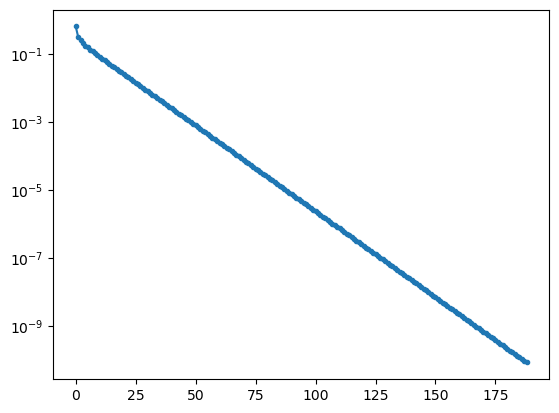

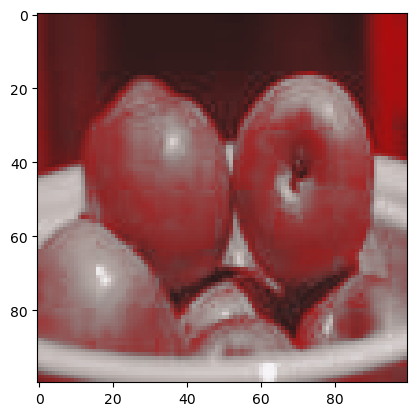

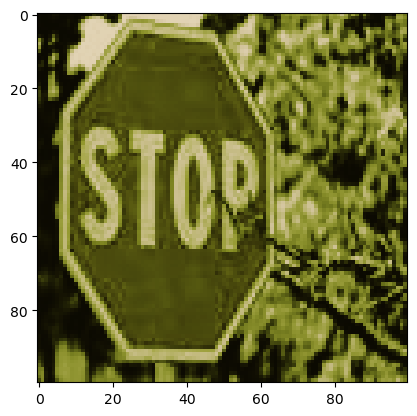

In [4]:
# Display
print("W =",W)
print("Marginal error:",err[-1])
plt.semilogy(err[:-1],".-")
# Compute resulting image
img12 = transfer_color(P,img1) # target image with source colors
img21 = transfer_color(P.T,img2) # symetry of problem
# show images:
plt.figure()
plt.imshow(array2matrix(img12),vmin=0, vmax=1)
plt.figure()
plt.imshow(array2matrix(img21),vmin=0, vmax=1)

In [5]:
# save in files
# array2image('img' + img1_nbr + img2_nbr + '.jpg', img12)
# array2image('img' + img2_nbr + img1_nbr + '.jpg', img21)

## Low rank approximation in Sinkhorn algorithm

In [20]:
delta=10**(-10)

### Studying how the rank affects the solution (compute images and compare them, compare the result in the non truncated and how far away are we )

In [6]:
rank_K_mat=np.linalg.matrix_rank(Kmat, tol=None, hermitian=False)
print(rank_K_mat, Kmat.shape)

405 (10000, 10000)


In [7]:
Kmat.shape

(10000, 10000)

In [27]:
k= 30
[u,v,W,err, P] = low_rank_Sinkhorn(Kmat,k,p,q,delta,maxtime=60)
#P = u*Kmat*v.T # coupling

195
0.2009432315826416


In [28]:
k= 500
[u,v,W,err, P] = low_rank_Sinkhorn(Kmat,k,p,q,delta,maxtime=60)
#P = u*Kmat*v.T # coupling

194
3.4996578693389893


In [29]:
err[-1]

4.7107149778180535e-11

In [30]:
min(err)

4.7107149778180535e-11

In [ ]:
# Display
print("W =",W)
print("Marginal error:",err[-1])
plt.semilogy(err[:-1],".-")
# Compute resulting image
low_img12 = transfer_color(P,img1) # target image with source colors
low_img21 = transfer_color(P.T,img2) # symetry of problem
# show images:
plt.figure()
plt.imshow(array2matrix(low_img12),vmin=0, vmax=1)
plt.figure()
plt.imshow(array2matrix(img12),vmin=0, vmax=1)
plt.figure()
plt.imshow(array2matrix(low_img21),vmin=0, vmax=1)

In [83]:
# compute the speed of the algorithm depending on the approximation k, runs in 1011 seconds, no need to rerun it have it 
#saved under csv
def running ():

    list_time_with_SVD=[]
    list_time_wtout_SVD=[]
    list_u=[]
    list_v=[]
    list_W=[]
    list_err_inf=[]
    [u,v,W,err] = sinkhorn(K,Kt,p,q,delta,maxtime=60)
    P_full= u*Kmat*v.T

    it=np.arange(25,rank_K_mat+30, 10) #adding a few values above the rank of K_mat

    for k in it: #only up to rank of K_mat. For k>=rank_K_mat, a rank k approximation of K_mat is K_mat
        start_time=time.time()
        [low_u,low_v,W,err, P_low, end_time] = low_rank_Sinkhorn(Kmat,k,p,q,delta,maxtime=60)
        execution_time=time.time()-start_time
        list_time_with_SVD.append(execution_time)
        list_time_wtout_SVD.append(end_time)
        list_err_inf.append(np.linalg.norm(P_low-P_full,np.inf))
        list_u.append(low_u)
        list_v.append(low_v)
        list_W.append(W)
    return [list_u, list_v, list_W, list_time_with_SVD, list_time_wtout_SVD, list_err_inf, it]

In [ ]:
import os 
import pandas

path_to_file='low_rank_sinkhorn.csv'

if (os.path.exists(path_to_file)):
    df = pandas.read_csv('low_rank_sinkhorn.csv')
    list_u = df['list_u'].tolist()
    list_v = df['list_v'].tolist()
    list_W = df['list_W'].tolist()
    list_err_inf = df['list_err_inf'].tolist()
    list_time_wtout_SVD = df['list_time_wtout_SVD'].tolist()
    list_time_with_SVD = df['list_time_with_SVD'].tolist()
    it=df["rank"].tolist()
else: 
    [list_u, list_v, list_W, list_time_with_SVD, list_time_wtout_SVD, list_err_inf, it]=running()
    dict = {'list_u': list_u, 'list_v': list_v, 'list_W': list_W, "time_with_SVD": list_time_with_SVD, 
        "time_wthout_SVD": list_time_wtout_SVD, "list_err_inf": list_err_inf, "rank": it}  
    df = pd.DataFrame(dict)
    # saving the dataframe 
    df.to_csv('low_rank_sinkhorn.csv')

In [51]:
S=time.time()
sinkhorn(K,Kt,p,q,delta,maxtime=60)
print(end_time, time.time()-S)

3.423652172088623 33.06727623939514


In [64]:
S=time.time()
[u,v,W,err, P, end_time]=low_rank_Sinkhorn(Kmat, 500,p,q,delta,maxtime=60)
print(end_time, time.time()-S)

3.47198748588562 48.206387996673584


In [65]:
err[-1]

4.706928750030596e-11

In [66]:
S=time.time()
[u,v,W,err, P, end_time]=low_rank_Sinkhorn(Kmat, 900,p,q,delta,maxtime=60)
print(end_time, time.time()-S)

6.105423212051392 92.88909602165222


In [67]:
err[-1]

4.708893846139435e-11

In [25]:
list_err_inf

[0.0002566594683584885, 6.189982726221495e-06]

In [26]:
list_err_2

[9.501630848226419e-05, 1.4060328572072457e-06]

In [27]:
list_W

[array(-9999), array(-15.13169752)]

In [28]:
list_u

[array([[6.52160917e+109],
        [8.43632235e+109],
        [1.08658379e+110],
        ...,
        [2.16130000e+109],
        [2.32462015e+109],
        [2.41375374e+109]]),
 array([[3.91208968e-07],
        [4.79736317e-07],
        [5.96240554e-07],
        ...,
        [1.69154847e-07],
        [1.82995252e-07],
        [1.90472776e-07]])]

In [29]:
list_v

[array([[2.65385302e-118],
        [2.64030337e-118],
        [2.77511729e-118],
        ...,
        [1.42434882e-116],
        [1.13854001e-116],
        [4.21227848e-117]]),
 array([[0.05034621],
        [0.0501362 ],
        [0.05237698],
        ...,
        [9.64646042],
        [3.35210605],
        [1.37611103]])]

In [22]:
np.linalg.norm(P_low-P_full,2)

0.007955833983691275

In [ ]:
ax_x=np.arange(1, rank_K_mat)
plt.plot(list_time, ax_x)
plt.plot(list_accuracy, ax_x)

In [76]:
#stocking list_u, list_v, list_W, list_err because it took a looong time to run 
import pandas as pd

# dictionary of lists  
dict = {'list_u': list_u, 'list_v': list_v, 'list_W': list_W, "time_with_SVD": list_time_with_SVD, 
        "time_wthout_SVD": list_time_wtout_SVD, "list_err_inf": list_err_inf, "rank": it}  
df = pd.DataFrame(dict)
# saving the dataframe 
df.to_csv('low_rank_sinkhorn.csv')

In [78]:
df.head()

,list_u,list_v,list_W,time_with_SVD,time_wthout_SVD,list_err_inf,rank
0,"[[57.955557865521946], [70.87499143960076], [8...","[[0.05066940789120188], [0.050453735957895554]...",537987506.9938161,6.488142,0.199616,3927.623695,25
1,"[[59.895242300574175], [73.20642130822173], [9...","[[0.05036766729464474], [0.05015747739285987],...",564266103.8711568,7.005674,0.243279,1989.533416,35
2,"[[59.43912680705648], [72.93089576616347], [90...","[[0.05034481045619478], [0.05013496853845067],...",563534065.753324,7.806888,0.341624,1562.956479,45
3,"[[59.515328501250366], [72.96029032931669], [9...","[[0.05035055764336423], [0.05014047225788163],...",564506910.6290563,8.203087,0.383068,463.675654,55
4,"[[59.46886723963598], [72.89726556259549], [90...","[[0.050352852736261416], [0.05014274277106474]...",564141823.3995044,9.228182,0.464253,188.952682,65


In [ ]:
import os 

path_to_file='low_rank_sinkhorn.csv'

if (os.path.exists(path_to_file)):
    df = pandas.read_csv('low_rank_sinkhorn.csv')
    list_u = df['list_u'].tolist()
    list_v = df['list_v'].tolist()
    list_W = df['list_W'].tolist()
    list_err_inf = df['list_err_inf'].tolist()
    list_time_wtout_SVD = df['list_time_wtout_SVD'].tolist()
    list_time_with_SVD = df['list_time_with_SVD'].tolist()
    it=df["rank"].tolist()
else: #create them 

### Study how much the color transfer is accelerated